## Premier League 23/24 Analysis
#### Summary:
In this project I investigated data from the Premier League season 2023/2024 to see what trends or insights I could extrapolate. This project is segmented into three sections: 
1. Data Cleaning
2. Exploratory Data Analysis
3. Machine Learning

Following is a outline of each section with key findings.

1. Data Cleaning:
- Match day data used: https://www.kaggle.com/datasets/mertbayraktar/english-premier-league-matches-20232024-season?resource=download
- Made a few changes like dropping unneccesary columns, mapping values to be more legible (e.g. 'LutonTown' -> 'Luton Town')
- The table originally had two rows for every match; one from the perspective of the home team and one from the perspective of the away team. I joined the table to itself to see all match information is on one row

2. Exploratory Data Analysis:
- The number of goals scored in a game is fairly independent of the individual responsible for refereeing. There were some outliers, but these people generally managed only a handful of games. Generally, the average goals of most referees is close to the mean of 3.28 games, indicating a high level of conformity to standards
- The factors with the highest correlation to points were: Goals For, xG, Shots on Target, and Possession. I was surprised to find that Avg Distance Covered actually had a negative correlation of -0.3. This may be explained by the possibility that teams out of possession may have to run more (and we have seen that less possession correlates to less points)
- Despite placing 15th, Everton actually had a top-four quality defense, only conceding 51 goals behind Man City (1st), Arsenal (2nd) and Liverpool (3rd)
- Newcastle had a fairly poor point-to-goal return, achieving the same points (60) as Manchester United with 85 goals scored to MU's 57
- By a large way, Liverpool had the most shots in the league with 781. Man City were the closest behind with 683 (87.5% as many shots). Despite this, Manchester City actually had more shots _on target_ (264 vs. 263)
- Final table rankings seem completely independent of average distance covered. Sheffield United covered the most ground but still finished bottom of the table. Man City still won the league despite being outran by teams like Liverpool, Chelsea, and Manchester United
- Man City didn't lose a single game at home all season
- Tottenham didn't draw a single game at home all season
- Burnley were the only team in the league to take more points away than at home (14 away, 10 home)

3. Machine Learning:
- Attempted to predict win/draw/loss based on features 
Features used in ML:
    - Home Team
    - Away Team
    - Home Possession
    - Shots of Target For
    - Shots on Target Against
- One-hot encoded team names worked better than label-encoded, I suspect because the model was not trying to interpret some sort of ordinal relationship between the values
- I developed a base model using KNN and found the best value for k to be 3 (which makes sense considering we are predicting for 3 potential outcomes) and found my best test accuracy to be 60.53%
- I developed a comparison model using Random Forest Classifier. Despite tuning the model, the best accuracy I could achieve was 63.81%

### 1. Data Cleaning

##### Changes implemented:
- Drop the following columns: Season, Comp, Notes, Match Report
- Changed teamnames to proper English
- Join df to itself to see each match as one record in the table, dropping and renaming columns where necessary. Reordered columns for readability.

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.colors import LinearSegmentedColormap

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv(r'Data\matches.csv', index_col = 0)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 760 entries, 1 to 40
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          760 non-null    object 
 1   Time          760 non-null    object 
 2   Comp          760 non-null    object 
 3   Round         760 non-null    object 
 4   Day           760 non-null    object 
 5   Venue         760 non-null    object 
 6   Result        760 non-null    object 
 7   GF            760 non-null    int64  
 8   GA            760 non-null    int64  
 9   Opponent      760 non-null    object 
 10  xG            760 non-null    float64
 11  xGA           760 non-null    float64
 12  Poss          760 non-null    float64
 13  Attendance    760 non-null    float64
 14  Captain       760 non-null    object 
 15  Formation     760 non-null    object 
 16  Referee       760 non-null    object 
 17  Match Report  760 non-null    object 
 18  Notes         0 non-null      float6

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes,Sh,SoT,Dist,FK,PK,PKatt,Season,Team
1,2023-08-11,20:00,Premier League,Matchweek 1,Fri,Away,W,3,0,Burnley,1.9,0.3,65.0,21572.0,Kevin De Bruyne,4-2-3-1,Craig Pawson,Match Report,NaN,17.0,8.0,13.9,0.0,0,0,2024,ManchesterCity
3,2023-08-19,20:00,Premier League,Matchweek 2,Sat,Home,W,1,0,Newcastle Utd,1.0,0.3,59.0,53419.0,Kyle Walker,4-2-3-1,Robert Jones,Match Report,NaN,14.0,4.0,17.9,0.0,0,0,2024,ManchesterCity
4,2023-08-27,14:00,Premier League,Matchweek 3,Sun,Away,W,2,1,Sheffield Utd,3.5,0.7,79.0,31336.0,Kyle Walker,4-2-3-1,Jarred Gillett,Match Report,NaN,29.0,9.0,17.3,2.0,0,1,2024,ManchesterCity
5,2023-09-02,15:00,Premier League,Matchweek 4,Sat,Home,W,5,1,Fulham,2.2,1.4,68.0,52899.0,Kyle Walker,4-2-3-1,Michael Oliver,Match Report,NaN,6.0,4.0,14.8,0.0,1,1,2024,ManchesterCity
6,2023-09-16,15:00,Premier League,Matchweek 5,Sat,Away,W,3,1,West Ham,3.6,0.9,68.0,62475.0,Kyle Walker,4-2-3-1,Andy Madley,Match Report,NaN,29.0,13.0,16.4,1.0,0,0,2024,ManchesterCity


In [3]:
# drop unhelpful columns
cols_to_drop = ['Season', 'Comp', 'Notes', 'Match Report']
df = df.drop(columns = cols_to_drop)

In [4]:
# rename teams
df['Team'] = df['Team'].replace({'ManchesterCity': 'Manchester City',
                                'AstonVilla': 'Aston Villa',
                                'TottenhamHotspur': 'Tottenham Hotspur',
                                'NewcastleUnited': 'Newcastle United',
                                'ManchesterUnited': 'Manchester United',
                                'WestHamUnited': 'West Ham United',
                                'LutonTown': 'Luton Town',
                                'NottinghamForest': 'Nottingham Forest',
                                'WolverhamptonWanderers' : 'Wolverhampton Wanderers',
                                'BrightonandHoveAlbion': 'Brighton',
                                'CrystalPalace': 'Crystal Palace',
                                'SheffieldUnited': 'Sheffield United'})

In [5]:
# split table by home and away, then join on date, time and referee
# logic here is that multiple games occur at same date, and even same time, but impossible for referee to be in two places at once
prem_df_home = df[df['Venue'] == 'Home'].sort_values(['Date', 'Time', 'Referee'])
prem_df_away = df[df['Venue'] == 'Away'].sort_values(['Date', 'Time', 'Referee'])
prem_df = prem_df_home.merge(prem_df_away, on = ['Date', 'Time', 'Referee'], suffixes = ['', '_Away'])

In [6]:
# columns to drop from new self-joined table
cols_to_drop = ['Venue', 'GA', 'Opponent', 'xGA', 'Round_Away', 'Day_Away', 'Venue_Away', 'GA_Away', 'Opponent_Away', 'xGA_Away', 'Attendance_Away']

# drop unnecessary colums
prem_df = prem_df.drop(cols_to_drop, axis = 1)

In [7]:
# columns to rename
rename_cols_map = {
    'Result': 'Home Result',
    'GF': 'Home GF',
    'xG': 'Home xG',
    'Poss': 'Home Poss',
    'Captain': 'Home Captain',
    'Formation': 'Home Formation',
    'Sh': 'Home Sh',
    'SoT': 'Home SoT',
    'Dist': 'Home Dist',
    'FK': 'Home FK',
    'PK': 'Home Pen',
    'PKatt': 'Home PKatt',
    'Team': 'Home Team',
    'Result_Away': 'Away Result',
    'GF_Away': 'Away GF',
    'xG_Away': 'Away xG',
    'Poss_Away': 'Away Poss',
    'Captain_Away': 'Away Captain',
    'Formation_Away': 'Away Formation',
    'Sh_Away': 'Away Sh',
    'SoT_Away': 'Away SoT',
    'Dist_Away': 'Away Dist',
    'FK_Away': 'Away FK',
    'PK_Away': 'Away Pen',
    'PKatt_Away': 'Away PKatt',
    'Team_Away': 'Away Team',
}

# rename columns
prem_df = prem_df.rename(mapper = rename_cols_map, axis = 1)

In [8]:
# reshuffle column order to increase readability
prem_df = prem_df[['Date', 'Time', 'Round', 'Day', 'Referee', 'Home Team', 'Home Result', 'Home GF', 'Home xG', 'Home Poss', 'Home Sh', 'Home SoT',\
                  'Home Dist', 'Home FK', 'Home Pen', 'Home Captain', 'Away Team', 'Away Result', 'Away GF', 'Away xG', 'Away Poss', 'Away Sh',\
                  'Away SoT', 'Away Dist', 'Away FK', 'Away Pen', 'Away Captain']]



In [9]:
# sanity check - 10 games per weekend, for 38 weeks = 380 rows
assert len(prem_df == 380)

# look at first record
print(prem_df.iloc[0])

Date                 2023-08-11
Time                      20:00
Round               Matchweek 1
Day                         Fri
Referee            Craig Pawson
Home Team               Burnley
Home Result                   L
Home GF                       0
Home xG                     0.3
Home Poss                  35.0
Home Sh                     6.0
Home SoT                    1.0
Home Dist                  14.9
Home FK                     0.0
Home Pen                      0
Home Captain        Josh Cullen
Away Team       Manchester City
Away Result                   W
Away GF                       3
Away xG                     1.9
Away Poss                  65.0
Away Sh                    17.0
Away SoT                    8.0
Away Dist                  13.9
Away FK                     0.0
Away Pen                      0
Away Captain    Kevin De Bruyne
Name: 0, dtype: object


### 2. Exploratory Data Analysis
##### Questions asked:
- 2.1 How Does Referee Selection Impact Goals Scored?
- 2.2 Which Factors Have the Greatest Impact on Results and Final Table Rank?
    - 2.2.1 Goals Scored and Goals Conceded
    - 2.2.2 xG
    - 2.2.3 Shots and Shots On Target
    - 2.2.4 Possession
    - 2.2.5 Distance Covered
    - 2.2.6 Home Form
    - 2.2.7 Away Form
    - 2.2.8 Proportion of Home and Away Points

#### 2.1 How Does Referee Selection Impact Goals Scored?
With a lot of scrutiny placed upon the standard of refereeing in English football in recent years, let's have a look at what impact, if any, choice of referee has on Premier League games.

In [10]:
# copy df
prem_ref_df = prem_df.copy()

Average number of goals in a Premier League match in season 23/24: 3.28


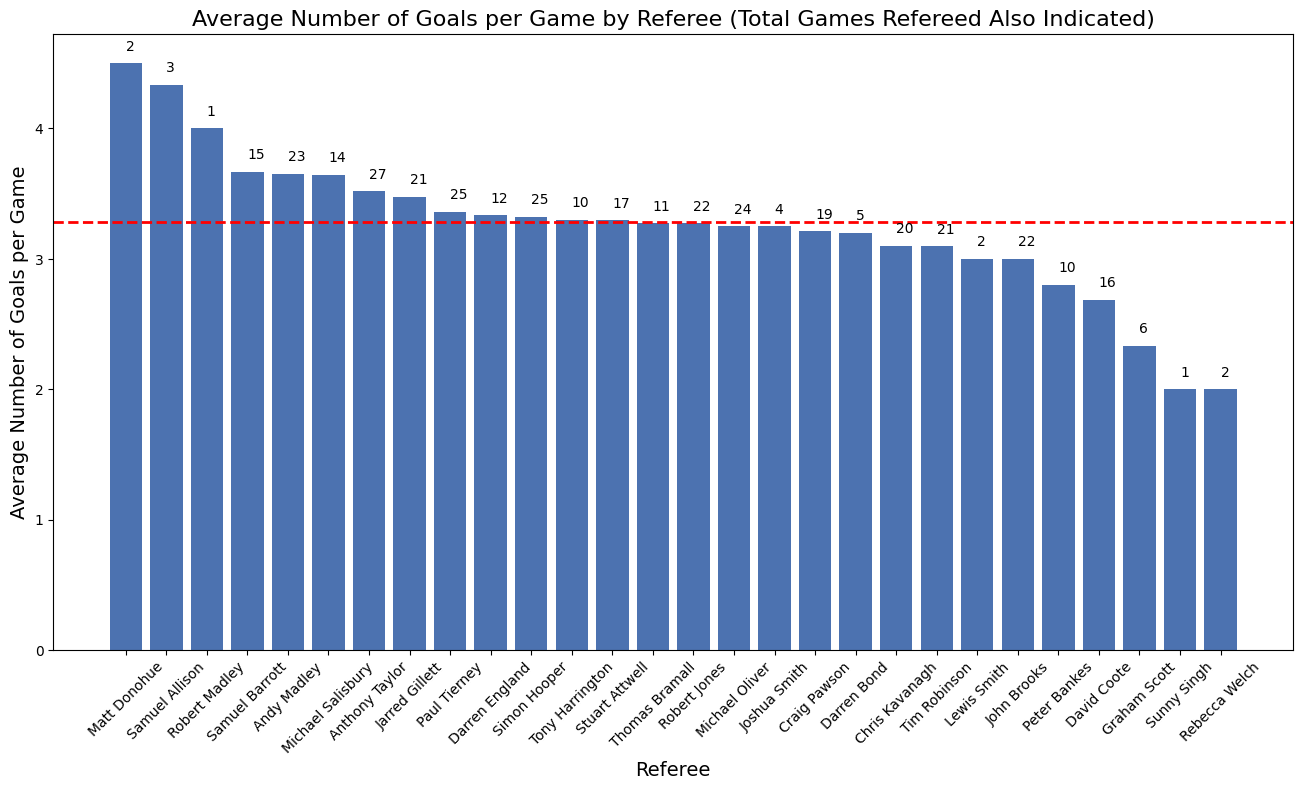

In [11]:
# total goals column
prem_ref_df['Total Goals'] = prem_ref_df['Home GF'] + prem_ref_df['Away GF']

# avg_goals per match (used as line in chart below)
avg_goals_per_match = prem_ref_df['Total Goals'].mean()

# calculate avg goals per game by ref, and total games
avg_goals_by_ref = prem_ref_df.groupby('Referee').agg(mean_goals = ('Total Goals', 'mean'),
                                                      total_games = ('Date', 'count')).sort_values(by = 'mean_goals', ascending = False)    

# matplotlib
plt.style.use('seaborn-v0_8-deep')
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
plt.bar(avg_goals_by_ref.index, avg_goals_by_ref['mean_goals'])
plt.title('Average Number of Goals per Game by Referee (Total Games Refereed Also Indicated)', fontsize = 16)
plt.xlabel('Referee', fontsize = 14)
plt.ylabel('Average Number of Goals per Game', fontsize = 14)
plt.xticks(rotation = 45)

# avg goals line
plt.axhline(y = avg_goals_per_match, color = 'r', linestyle = '--', linewidth = 2)

# total games referreed label
def add_labels(variables, values):
    for i in range(len(variables)):
        plt.text(i, ax.patches[i].get_height() + 0.1, avg_goals_by_ref['total_games'].iloc[i])

add_labels(avg_goals_by_ref.index, avg_goals_by_ref['total_games'])


print(f'Average number of goals in a Premier League match in season 23/24: {avg_goals_per_match:.2f}')

As we can see, most data points fit very closely to the average, indicating referee selection doesn't impact number of goals greatly, or most referees follow a standard of refereeing closely. We can see variables that could be considered outliers, such as Matt Donohue or Rebecca Welch, be explained by the fact these referees were in charge of much fewer games than average.

#### 2.2 Which Factors Have the Greatest Impact on Results and Final Table Rank?
I would like to examine how metrics like number of shots, GF, GA, and xG impact results and points.

In [12]:
# import premier league final table 23/24
prem_table_df = pd.read_csv(r'Data\premier league standings 23-24.csv', index_col = 0)
print(prem_table_df.head())

                   Team   W   D   L  GF  GA  GD  Points
Rank                                                   
1       Manchester City  28   7   3  96  34  62      91
2               Arsenal  28   5   5  91  29  62      89
3             Liverpool  24  10   4  86  41  45      82
4           Aston Villa  20   8  10  76  61  15      68
5     Tottenham Hotspur  20   6  12  74  61  13      66


In [13]:
# copy df
prem_table_stats = prem_table_df.copy()

# create new columns
prem_table_stats['Home Shots'] = 0
prem_table_stats['Home Shots On Target'] = 0
prem_table_stats['Home Avg Distance'] = 0.0
prem_table_stats['Home Avg Possession'] = 0.0
prem_table_stats['Home xG'] = 0.0
prem_table_stats['Home GF'] = 0
prem_table_stats['Home GA'] = 0
prem_table_stats['Away Shots'] = 0
prem_table_stats['Away Shots'] = 0
prem_table_stats['Away Shots On Target'] = 0
prem_table_stats['Away Avg Distance'] = 0.0
prem_table_stats['Away Avg Possession'] = 0.0
prem_table_stats['Away xG'] = 0.0
prem_table_stats['Away GF'] = 0
prem_table_stats['Away GA'] = 0

# list of teams
teams = prem_table_stats['Team']

# iterate over match day results df, and parse stats into league table df
for team in teams:
    for idk,row in prem_df.iterrows():
        if row['Home Team'] == team:
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Home Shots'] += row['Home Sh']
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Home Shots On Target'] += row['Home SoT']
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Home Avg Distance'] += row['Home Dist'] 
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Home Avg Possession'] += row['Home Poss']
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Home xG'] += row['Home xG']
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Home GF'] += row['Home GF']
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Home GA'] += row['Away GF']
        elif row['Away Team'] == team:
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Away Shots'] += row['Away Sh']
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Away Shots On Target'] += row['Away SoT']
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Away Avg Distance'] += row['Away Dist'] 
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Away Avg Possession'] += row['Away Poss']
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Away xG'] += row['Away xG']
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Away GF'] += row['Away GF']
            prem_table_stats.loc[prem_table_stats['Team'] == team, 'Away GA'] += row['Home GF']
        else:
            pass

# update stats that are already averaged or proportions (distance is already average of team, and possession is a percentage)
prem_table_stats['Home Avg Distance'] = np.round(prem_table_stats['Home Avg Distance'] / 19, 2)
prem_table_stats['Home Avg Possession'] = np.round(prem_table_stats['Home Avg Possession'] / 19, 1)
prem_table_stats['Away Avg Distance'] = np.round(prem_table_stats['Away Avg Distance'] / 19, 2)
prem_table_stats['Away Avg Possession'] = np.round(prem_table_stats['Away Avg Possession'] / 19, 1)

# combined stats (home and away)
prem_table_stats['Combined Shots'] = prem_table_stats['Home Shots'] + prem_table_stats['Away Shots']
prem_table_stats['Combined Shots On Target'] = prem_table_stats['Home Shots On Target'] + prem_table_stats['Away Shots On Target']
prem_table_stats['Combined Avg Distance'] = np.round((prem_table_stats['Home Avg Distance'] + prem_table_stats['Away Avg Distance']) / 2, 2)
prem_table_stats['Combined Avg Possession'] = np.round((prem_table_stats['Home Avg Possession'] + prem_table_stats['Away Avg Possession']) / 2, 1)
prem_table_stats['Combined xG'] = prem_table_stats['Home xG'] + prem_table_stats['Away xG']

prem_table_stats.head()

,Team,W,D,L,GF,GA,GD,Points,Home Shots,Home Shots On Target,Home Avg Distance,Home Avg Possession,Home xG,Home GF,Home GA,Away Shots,Away Shots On Target,Away Avg Distance,Away Avg Possession,Away xG,Away GF,Away GA,Combined Shots,Combined Shots On Target,Combined Avg Distance,Combined Avg Possession,Combined xG
Rank,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Manchester City,28,7,3,96,34,62,91,363,123,16.58,66.9,40.6,51,16,320,141,16.72,63.5,40.0,45,18,683,264,16.65,65.2,80.6
2,Arsenal,28,5,5,91,29,62,89,356,118,15.89,58.7,43.6,48,16,291,91,15.82,57.6,32.7,43,13,647,209,15.86,58.2,76.3
3,Liverpool,24,10,4,86,41,45,82,471,165,17.53,62.6,54.8,49,17,310,98,17.12,59.9,33.0,37,24,781,263,17.33,61.2,87.8
4,Aston Villa,20,8,10,76,61,15,68,277,100,16.08,53.7,39.0,48,28,234,82,16.02,52.5,24.5,28,33,511,182,16.05,53.1,63.5
5,Tottenham Hotspur,20,6,12,74,61,13,66,323,114,16.25,61.4,39.2,38,27,259,93,17.06,61.8,28.8,36,34,582,207,16.66,61.6,68.0


<Axes: >

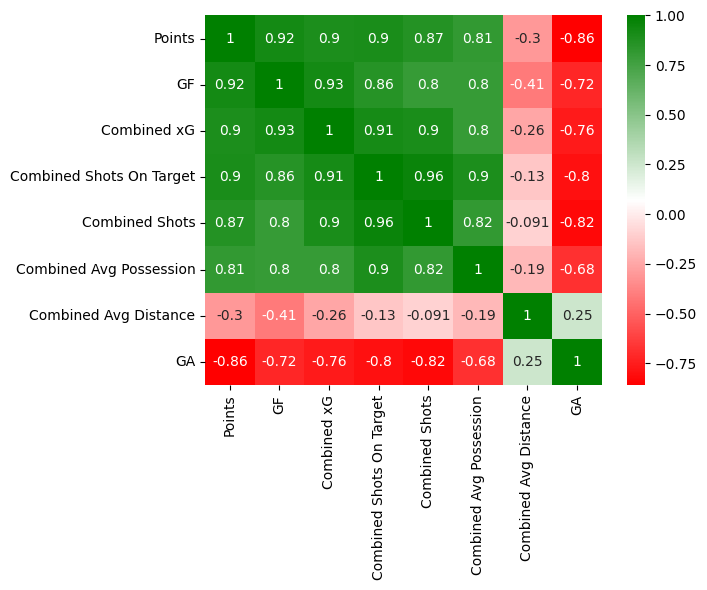

In [14]:
# correlation matrix of various variables
cols = ['Points', 'GF', 'Combined xG', 'Combined Shots On Target', 'Combined Shots', 'Combined Avg Possession', 'Combined Avg Distance', 'GA']
cmap = LinearSegmentedColormap.from_list('rg', ["r", "w", "g"], N = 256) 
sns.heatmap(prem_table_stats[cols].corr(), cmap = cmap, annot = True)

So unsurprisingly, there is a very strong correlation between points and goals, xG (or chances created), shots (on target or otherwise), and possession. Additionally, points has a strong negative correlation with goals conceded, as we obviously would expect.
However, I must admit I'm very surprised to see that points has a negative correlation with distance covered. I thought the greater distances covered by players, the more opportunities would arise to create chances, and the more opposition opportunities denied.

#### 2.2.1 Goals Scored and Goals Conceded

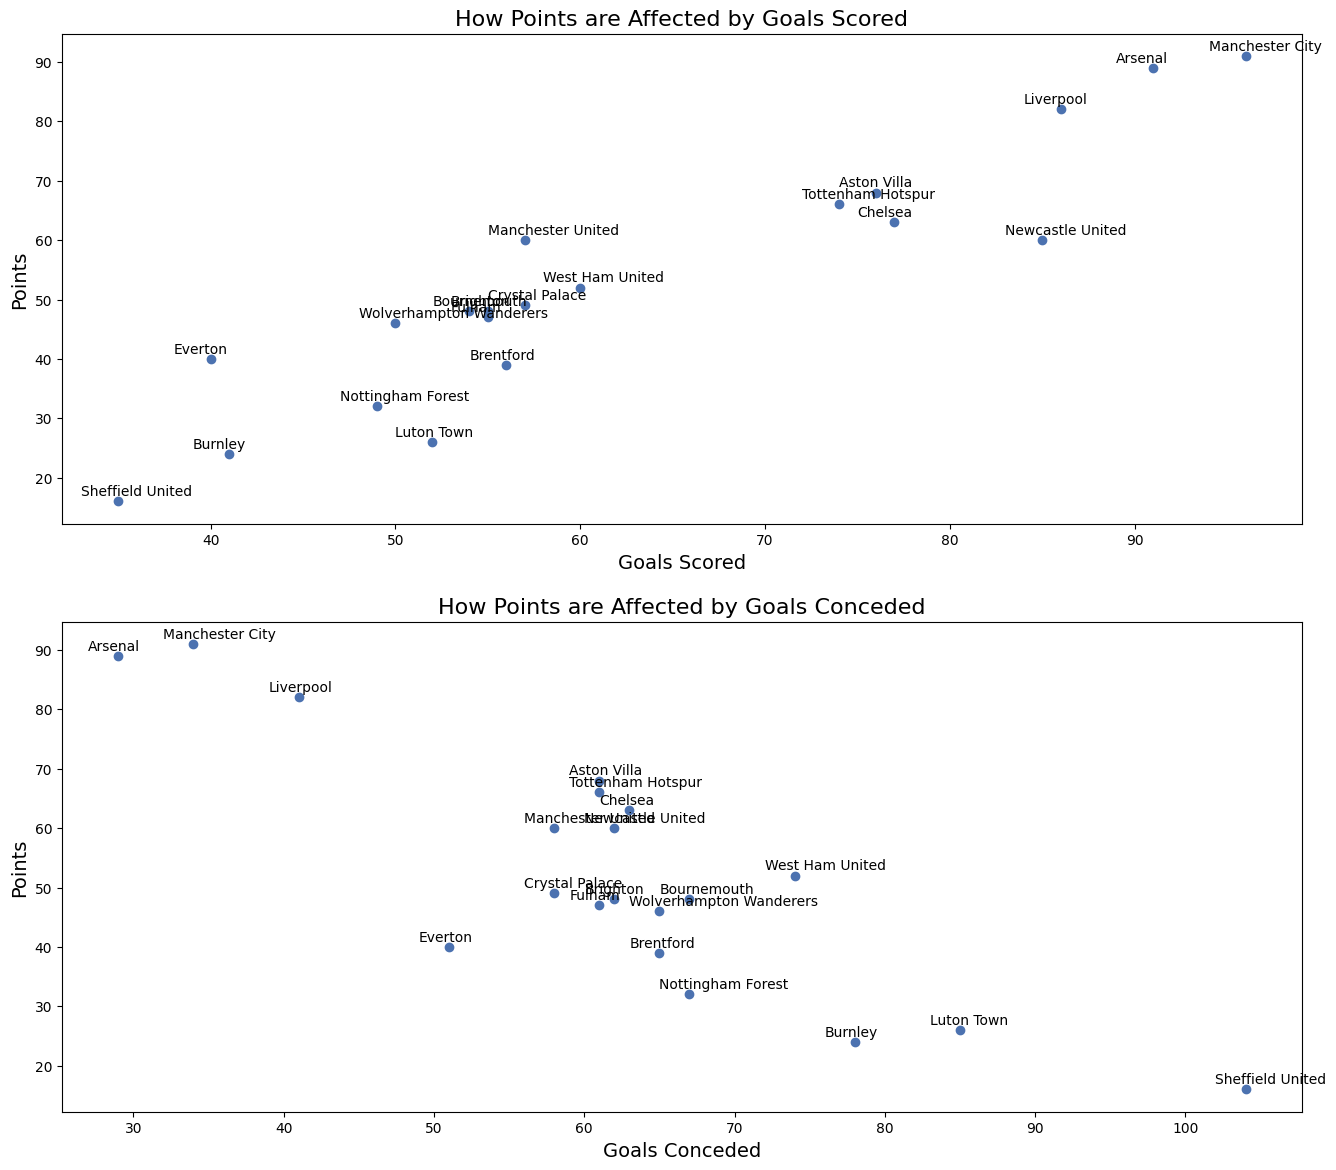

In [15]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches([16, 14])

# goals scored
ax[0].scatter(prem_table_stats['GF'], prem_table_stats['Points'])
ax[0].set_title('How Points are Affected by Goals Scored', fontsize = 16)
ax[0].set_xlabel('Goals Scored', fontsize = 14)
ax[0].set_ylabel('Points', fontsize = 14)

# goals conceded
ax[1].scatter(prem_table_stats['GA'], prem_table_stats['Points'])
ax[1].set_title('How Points are Affected by Goals Conceded', fontsize = 16)
ax[1].set_xlabel('Goals Conceded', fontsize = 14)
ax[1].set_ylabel('Points', fontsize = 14)

# annotate goals scored
for i, txt in enumerate(prem_table_stats['Team']):
    ax[0].annotate(txt, (prem_table_stats.iloc[i]['GF'] - 2, prem_table_stats.iloc[i]['Points'] + 1))

# annotate goals conceded
for i, txt in enumerate(prem_table_stats['Team']):
    ax[1].annotate(txt, (prem_table_stats.iloc[i]['GA'] - 2, prem_table_stats.iloc[i]['Points'] + 1))

What's most notable here are the points-to-goals-scored ratios of both Everton and Newcastle, for contrasting reasons.

It's clear to see Everton scored the second least goals in the 23/24 season, with only Sheffield scoring less, however they managed to pick up more points than other teams like Brentford who scored a lot more goals. This can be attributed to Everton's ironclad defense in relation to their lacking firepower up top. We can see that Everton, although scoring very few goals, actually had the best defense in the league behind Arsenal, Man City and Liverpool. In other words, Everton had a top 4 quality defense!

Newcastle have the exact opposite problem - scoring goals is not a problem, but they have a relatively leaky defense. Despite considerably outscoring Chelsea, Tottenham, and Aston Villa, their goals conceded is about the same, which ultimately denied Newcastle a top 4 finish. This suggests Newcastle had a few games they won very convincingly, but overall their form was inconsistent.

#### 2.2.2 xG

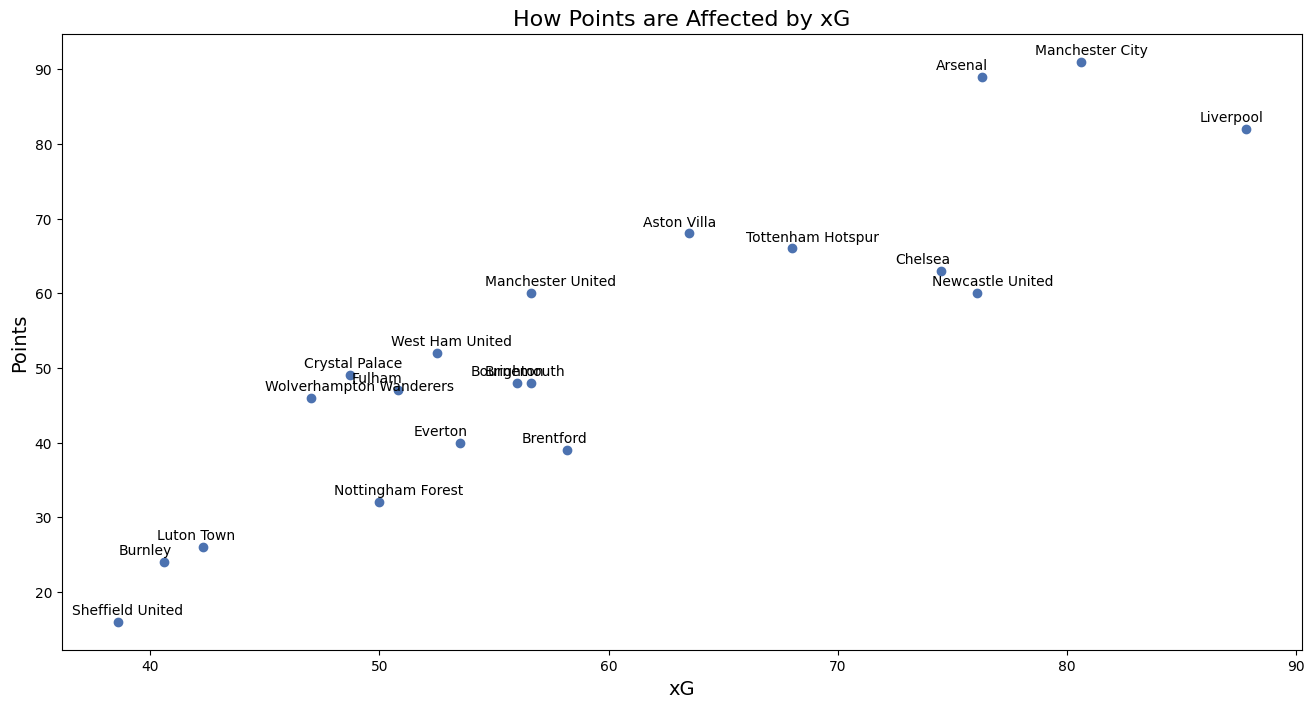

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
plt.scatter(prem_table_stats['Combined xG'], prem_table_stats['Points'])
plt.title('How Points are Affected by xG', fontsize = 16)
plt.xlabel('xG', fontsize = 14)
plt.ylabel('Points', fontsize = 14)

for i, txt in enumerate(prem_table_stats['Team']):
    ax.annotate(txt, (prem_table_stats.iloc[i]['Combined xG'] - 2, prem_table_stats.iloc[i]['Points'] + 1))

#### 2.2.3 Shots and Shots On Target

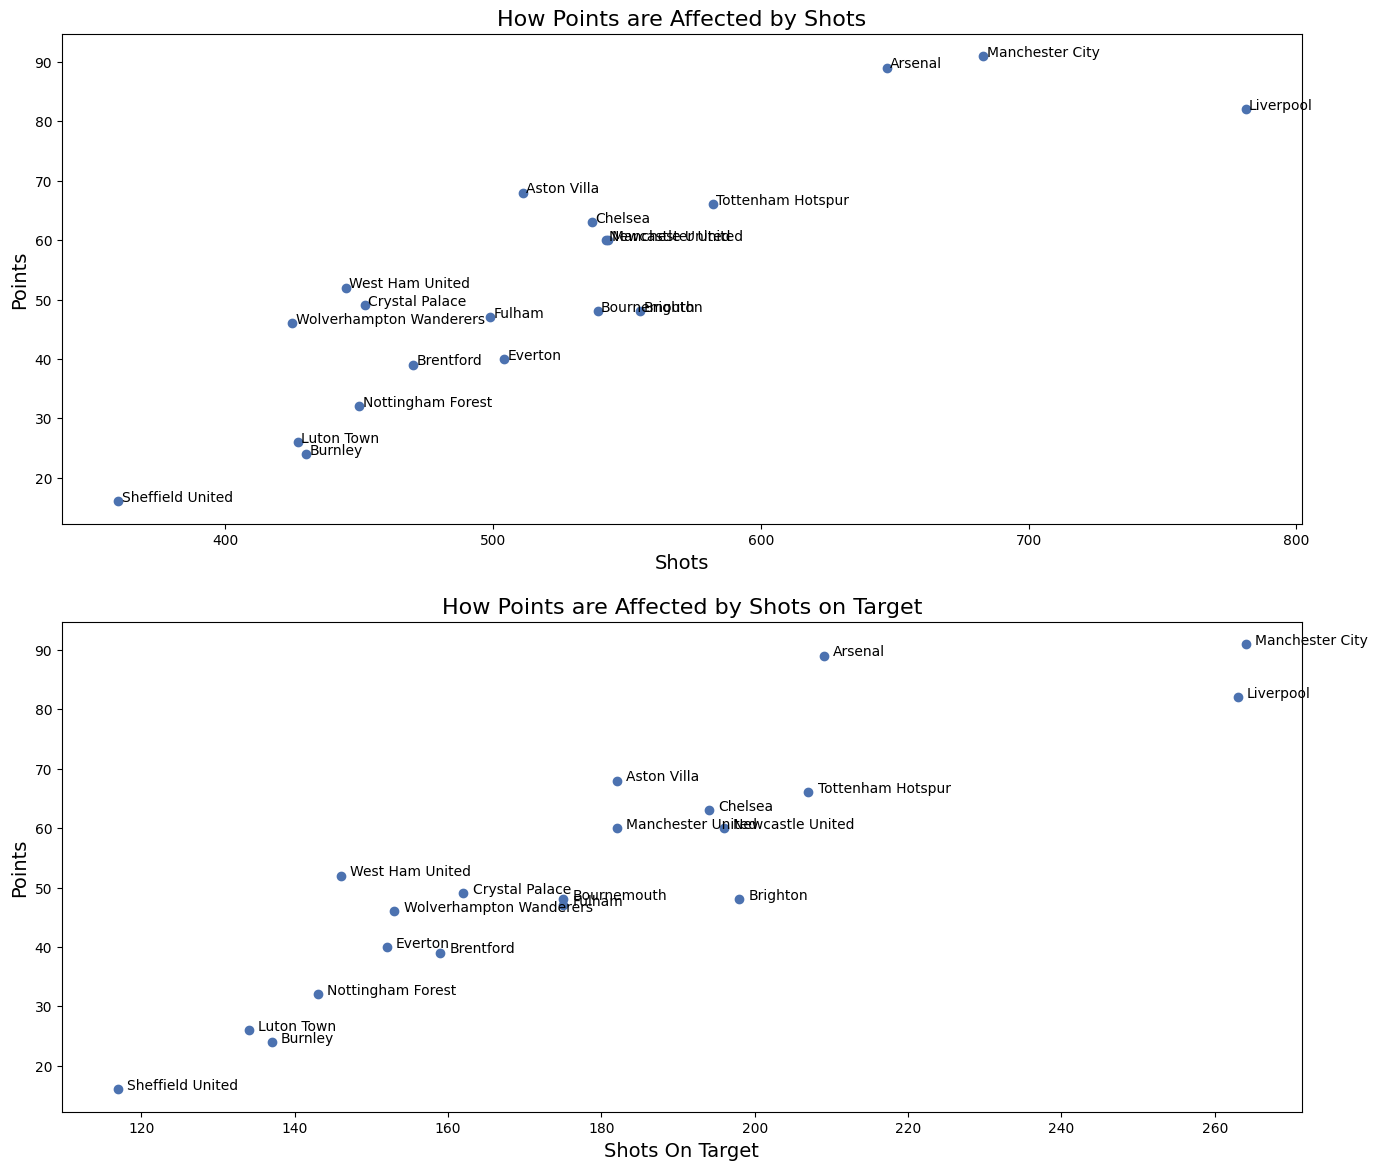

In [17]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches([16, 14])

# shots
ax[0].scatter(prem_table_stats['Combined Shots'], prem_table_stats['Points'])
ax[0].set_title('How Points are Affected by Shots', fontsize = 16)
ax[0].set_xlabel('Shots', fontsize = 14)
ax[0].set_ylabel('Points', fontsize = 14)

# shots on target
ax[1].scatter(prem_table_stats['Combined Shots On Target'], prem_table_stats['Points'])
ax[1].set_title('How Points are Affected by Shots on Target', fontsize = 16)
ax[1].set_xlabel('Shots On Target', fontsize = 14)
ax[1].set_ylabel('Points', fontsize = 14)

# annotate goals scored
for i, txt in enumerate(prem_table_stats['Team']):
    ax[0].annotate(txt, (prem_table_stats.iloc[i]['Combined Shots'] + 1.3, prem_table_stats.iloc[i]['Points']))

# annotate goals conceded
for i, txt in enumerate(prem_table_stats['Team']):
    ax[1].annotate(txt, (prem_table_stats.iloc[i]['Combined Shots On Target'] + 1.2, prem_table_stats.iloc[i]['Points']))

It's interesting to note here that Liverpool had, by a long way, the most shots of any team. They had 781 shots in total, with Man City being the closest behind them with 683 (87.5% as many shots). Regardless, Manchester City still ended the season with more shots _on target_ (264 v 263). The key factor can perhaps be attributed to the respective number 9s of each team. Darwin Núñez of Liverpool was infamously wasteful in front of goal in the 23/24 season, while Erling Haaland was positively ruthless. To quantify this with a metric, according to premierleague.com, Núñez had a shot accuracy of 43% while Haaland had an accuracy of 49%. If Núñez had the same accuracy, perhaps Liverpool could have scored more goals and closed the gap at the top.

#### 2.2.4 Possession

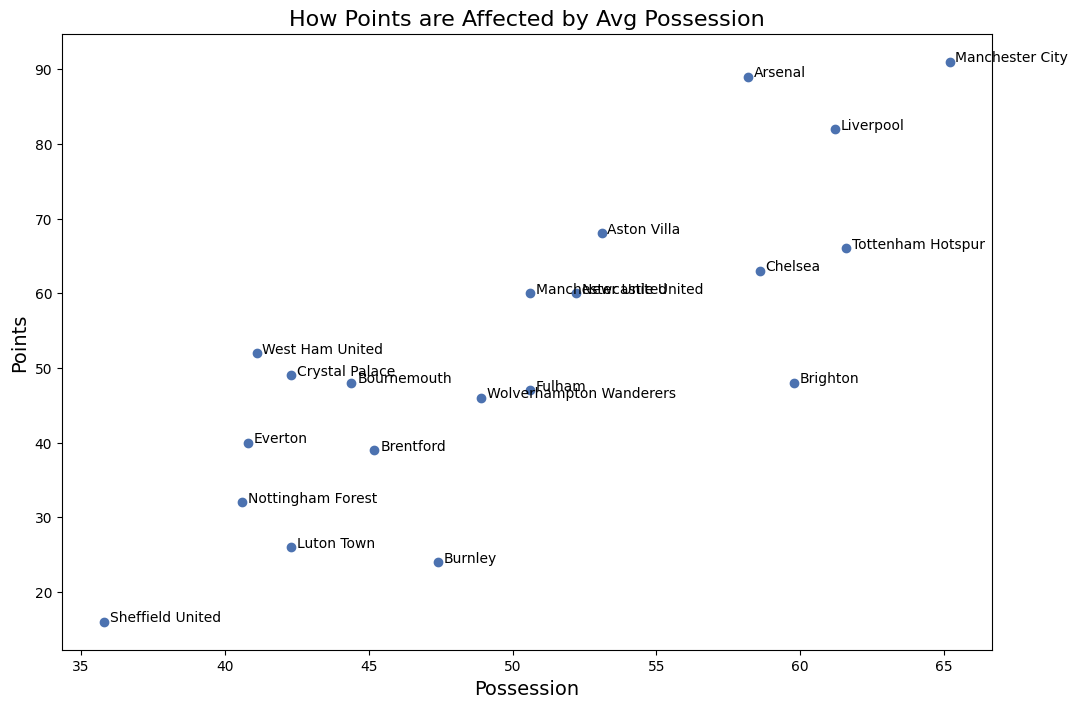

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches([12, 8])
plt.scatter(prem_table_stats['Combined Avg Possession'], prem_table_stats['Points'])
plt.title('How Points are Affected by Avg Possession', fontsize = 16)
plt.xlabel('Possession', fontsize = 14)
plt.ylabel('Points', fontsize = 14)

for i, txt in enumerate(prem_table_stats['Team']):
    ax.annotate(txt, (prem_table_stats.iloc[i]['Combined Avg Possession'] + 0.2, prem_table_stats.iloc[i]['Points']))

#### 2.2.5 Distance Covered

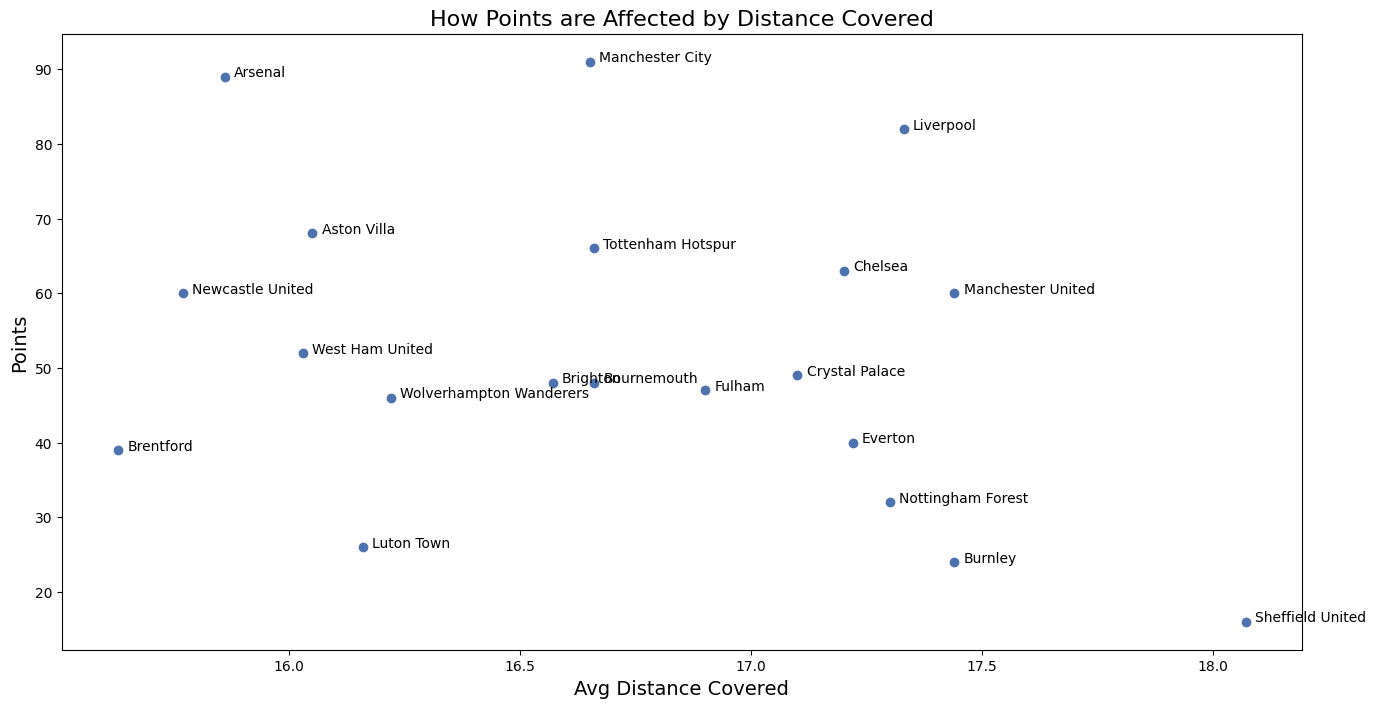

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
plt.scatter(prem_table_stats['Combined Avg Distance'], prem_table_stats['Points'])
plt.title('How Points are Affected by Distance Covered', fontsize = 16)
plt.xlabel('Avg Distance Covered', fontsize = 14)
plt.ylabel('Points', fontsize = 14)

for i, txt in enumerate(prem_table_stats['Team']):
    ax.annotate(txt, (prem_table_stats.iloc[i]['Combined Avg Distance'] + 0.02, prem_table_stats.iloc[i]['Points']))

In [20]:
prem_table_stats.sort_values('Combined Avg Distance', ascending = False)

,Team,W,D,L,GF,GA,GD,Points,Home Shots,Home Shots On Target,Home Avg Distance,Home Avg Possession,Home xG,Home GF,Home GA,Away Shots,Away Shots On Target,Away Avg Distance,Away Avg Possession,Away xG,Away GF,Away GA,Combined Shots,Combined Shots On Target,Combined Avg Distance,Combined Avg Possession,Combined xG
Rank,,,,,,,,,,,,,,,,,,,,,,,,,,,
20,Sheffield United,3,7,28,35,104,-69,16,202,62,17.63,37.0,24.3,19,57,158,55,18.51,34.7,14.3,16,47,360,117,18.07,35.8,38.6
19,Burnley,5,9,24,41,78,-37,24,252,70,17.54,51.5,22.5,19,43,178,67,17.35,43.3,18.1,22,35,430,137,17.44,47.4,40.6
8,Manchester United,18,6,14,57,58,-1,60,314,108,17.17,53.5,32.3,31,28,229,74,17.71,47.6,24.3,26,30,543,182,17.44,50.6,56.6
3,Liverpool,24,10,4,86,41,45,82,471,165,17.53,62.6,54.8,49,17,310,98,17.12,59.9,33.0,37,24,781,263,17.33,61.2,87.8
17,Nottingham Forest,9,9,20,49,67,-18,32,253,73,17.17,41.7,25.0,27,30,197,70,17.44,39.4,25.0,22,37,450,143,17.30,40.6,50.0
15,Everton,13,9,16,40,51,-11,40,293,91,16.55,42.0,31.8,22,18,211,61,17.88,39.7,21.7,18,33,504,152,17.22,40.8,53.5
6,Chelsea,18,9,11,77,63,14,63,304,109,17.26,58.1,44.3,44,26,233,85,17.13,59.1,30.2,33,37,537,194,17.20,58.6,74.5
10,Crystal Palace,13,10,15,57,58,-1,49,255,92,16.90,45.2,27.4,37,26,197,70,17.29,39.4,21.3,20,32,452,162,17.10,42.3,48.7
13,Fulham,13,8,17,55,61,-6,47,254,81,16.64,53.9,27.8,31,24,245,94,17.15,47.3,23.0,24,37,499,175,16.90,50.6,50.8


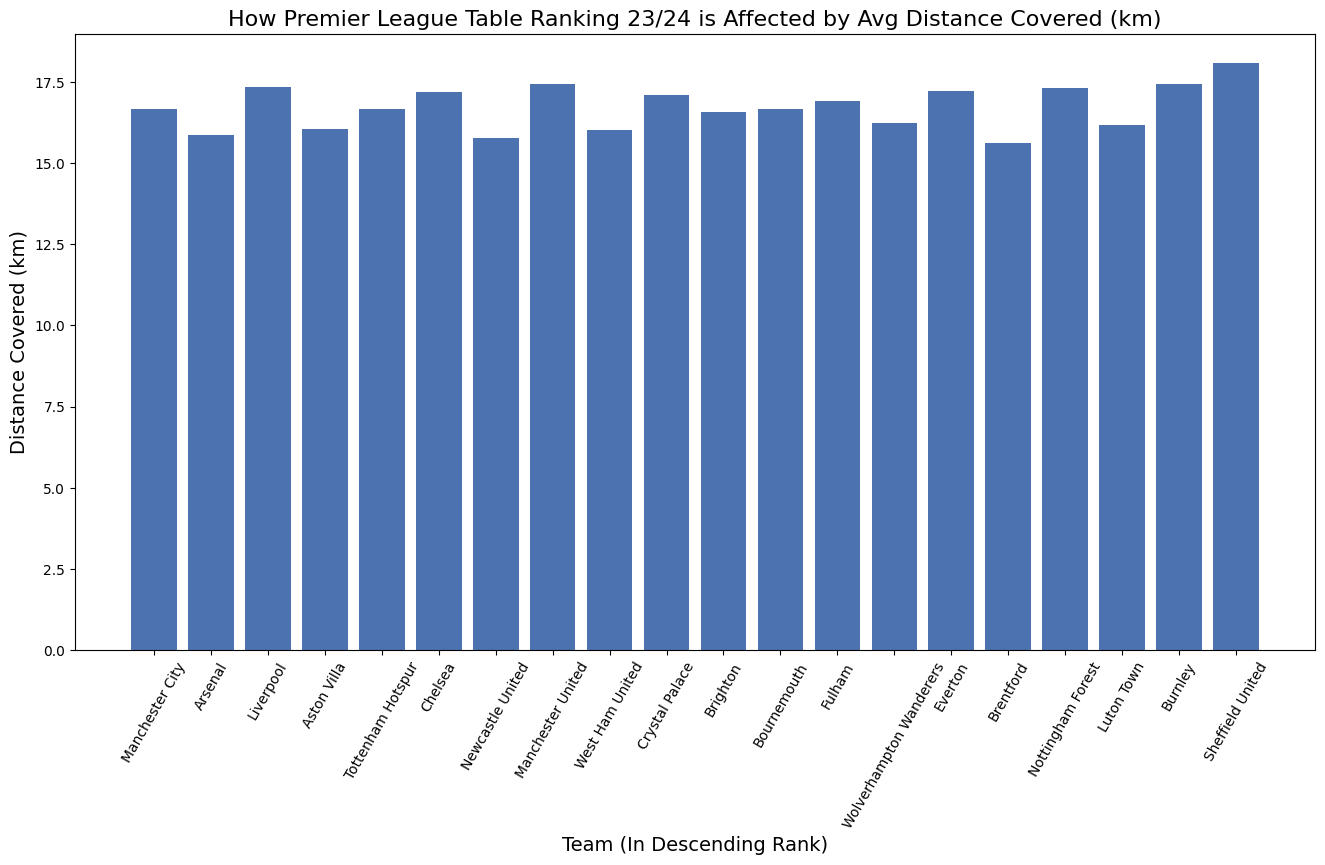

The Standard Deviation of Avg Distance Covered is: 0.65


In [21]:
# matplotlib
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
plt.bar(prem_table_stats['Team'], prem_table_stats['Combined Avg Distance'])
plt.title('How Premier League Table Ranking 23/24 is Affected by Avg Distance Covered (km)', fontsize = 16)
plt.xlabel('Team (In Descending Rank)', fontsize = 14)
plt.ylabel('Distance Covered (km)', fontsize = 14)
plt.xticks(rotation = 60)
plt.show()

print(f'The Standard Deviation of Avg Distance Covered is: {np.std(prem_table_stats["Combined Avg Distance"]):.2f}')

We can see from the barchart above that there wasn't much variability in how much different teams ran overall. This is confirmed with a low standard deviation of 0.65. Poor Sheffield United ran the most and still ended up bottom of the pile.

#### 2.2.6 Home Form

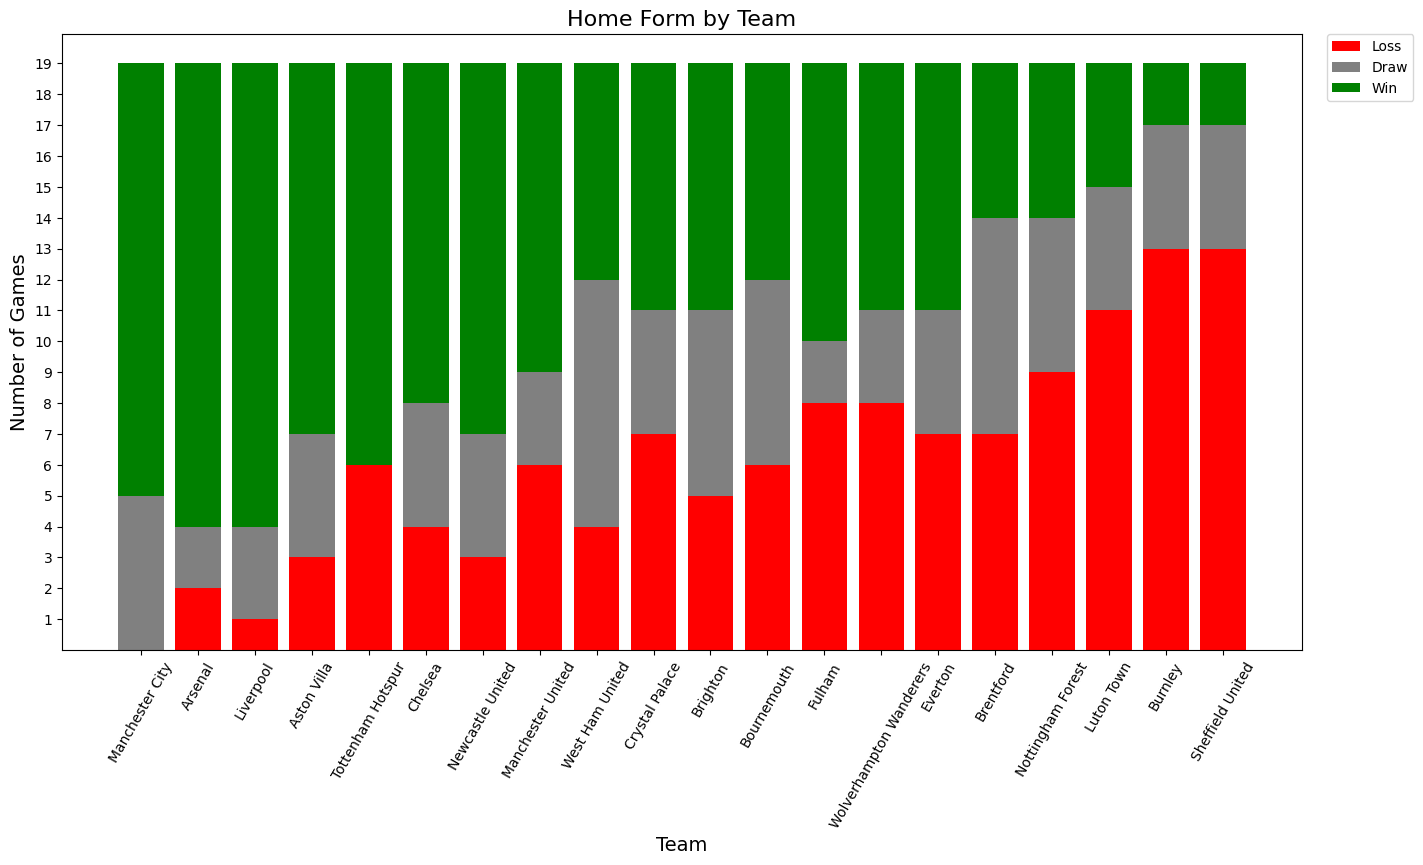

In [22]:
# home_form df
home_form = pd.DataFrame({
    'Team': ['Manchester City', 'Arsenal', 'Liverpool', 'Aston Villa', 'Tottenham Hotspur', 'Chelsea', 'Newcastle United', 'Manchester United', 'West Ham United', 'Crystal Palace', 'Brighton', 'Bournemouth', 'Fulham', 'Wolverhampton Wanderers', 'Everton', 'Brentford', 'Nottingham Forest', 'Luton Town', 'Burnley', 'Sheffield United'],
    'Wins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Draws': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Losses': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
})

# fill home_form df
for lab, row in prem_df.iterrows():
    if row['Home Result'] == 'W':
        home_form.loc[home_form['Team'] == row['Home Team'], 'Wins'] += 1
    elif row['Home Result'] == 'D':
        home_form.loc[home_form['Team'] == row['Home Team'], 'Draws'] += 1
    else:
        home_form.loc[home_form['Team'] == row['Home Team'], 'Losses'] += 1

# stacked bar chart of results from home games
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
plt.bar(home_form['Team'], home_form['Losses'], color = 'r')
plt.bar(home_form['Team'], home_form['Draws'], bottom = home_form['Losses'], color = 'grey')
plt.bar(home_form['Team'], home_form['Wins'], bottom = home_form['Losses'] + home_form['Draws'], color = 'g')
plt.xlabel('Team', fontsize = 14)
plt.ylabel('Number of Games', fontsize = 14)
plt.title('Home Form by Team', fontsize = 16)
plt.legend(['Loss', 'Draw', 'Win'], bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
plt.xticks(rotation = 60)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
plt.show()

Most notably here, Man City didn't lose a home game all season in the Premier League.
Furthermore, Tottenham didn't draw a single game at home!

#### 2.2.7 Away Form

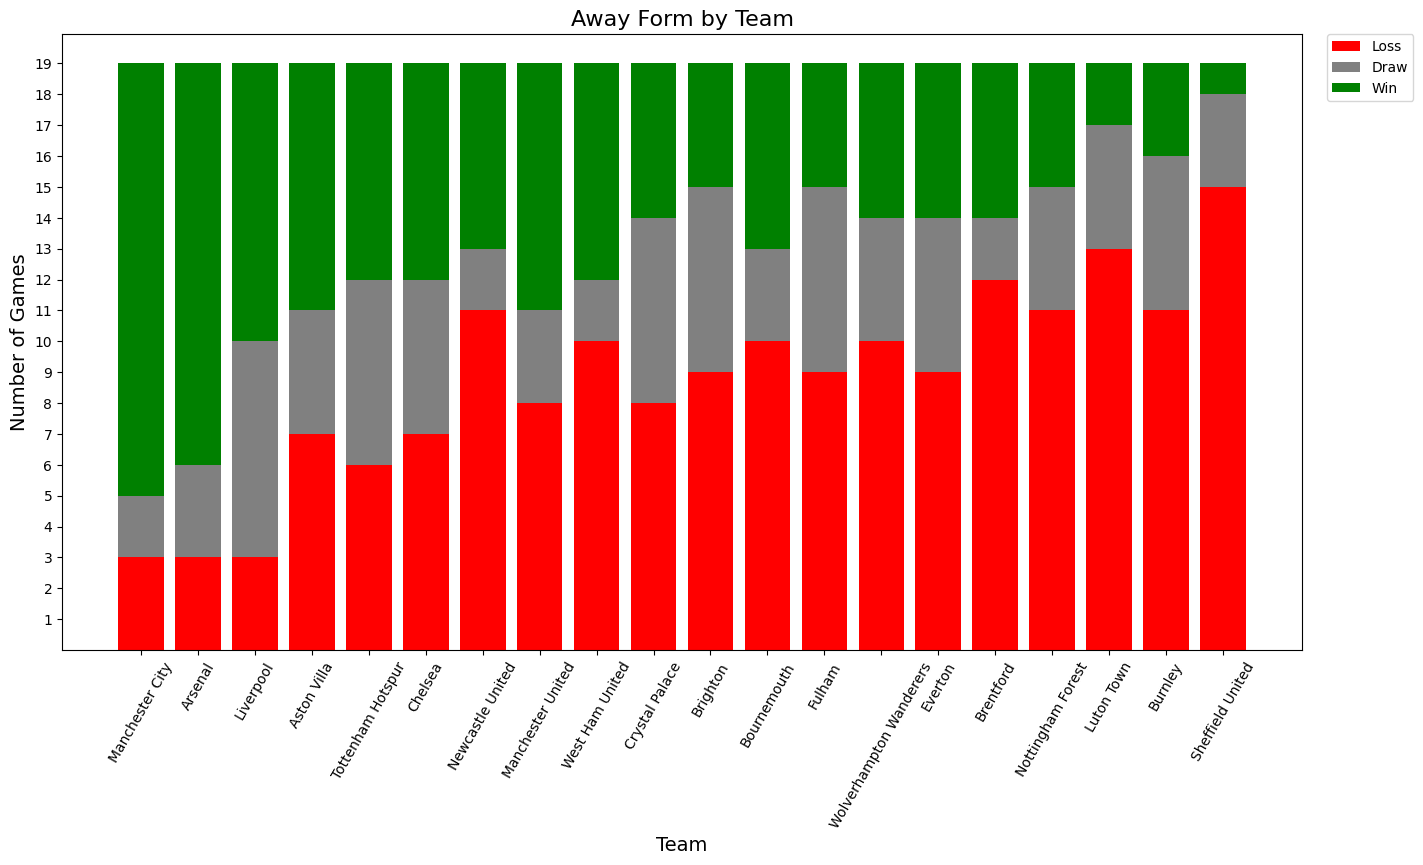

In [23]:
# away_form df
away_form = pd.DataFrame({
    'Team': ['Manchester City', 'Arsenal', 'Liverpool', 'Aston Villa', 'Tottenham Hotspur', 'Chelsea', 'Newcastle United', 'Manchester United', 'West Ham United', 'Crystal Palace', 'Brighton', 'Bournemouth', 'Fulham', 'Wolverhampton Wanderers', 'Everton', 'Brentford', 'Nottingham Forest', 'Luton Town', 'Burnley', 'Sheffield United'],
    'Wins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Draws': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'Losses': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
})

# fill away_form df
for lab, row in prem_df.iterrows():
    if row['Away Result'] == 'W':
        away_form.loc[away_form['Team'] == row['Away Team'], 'Wins'] += 1
    elif row['Away Result'] == 'D':
        away_form.loc[away_form['Team'] == row['Away Team'], 'Draws'] += 1
    else:
        away_form.loc[away_form['Team'] == row['Away Team'], 'Losses'] += 1
   
# stacked bar chart of results from away games
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
plt.bar(away_form['Team'], away_form['Losses'], color = 'r')
plt.bar(away_form['Team'], away_form['Draws'], bottom = away_form['Losses'], color = 'grey')
plt.bar(away_form['Team'], away_form['Wins'], bottom = away_form['Losses'] + away_form['Draws'], color = 'g')
plt.xlabel('Team', fontsize = 14)
plt.ylabel('Number of Games', fontsize = 14)
plt.title('Away Form by Team', fontsize = 16)
plt.legend(['Loss', 'Draw', 'Win'], bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
plt.xticks(rotation = 60)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
plt.show()

#### 2.2.8 Proportion of Home and Away Points

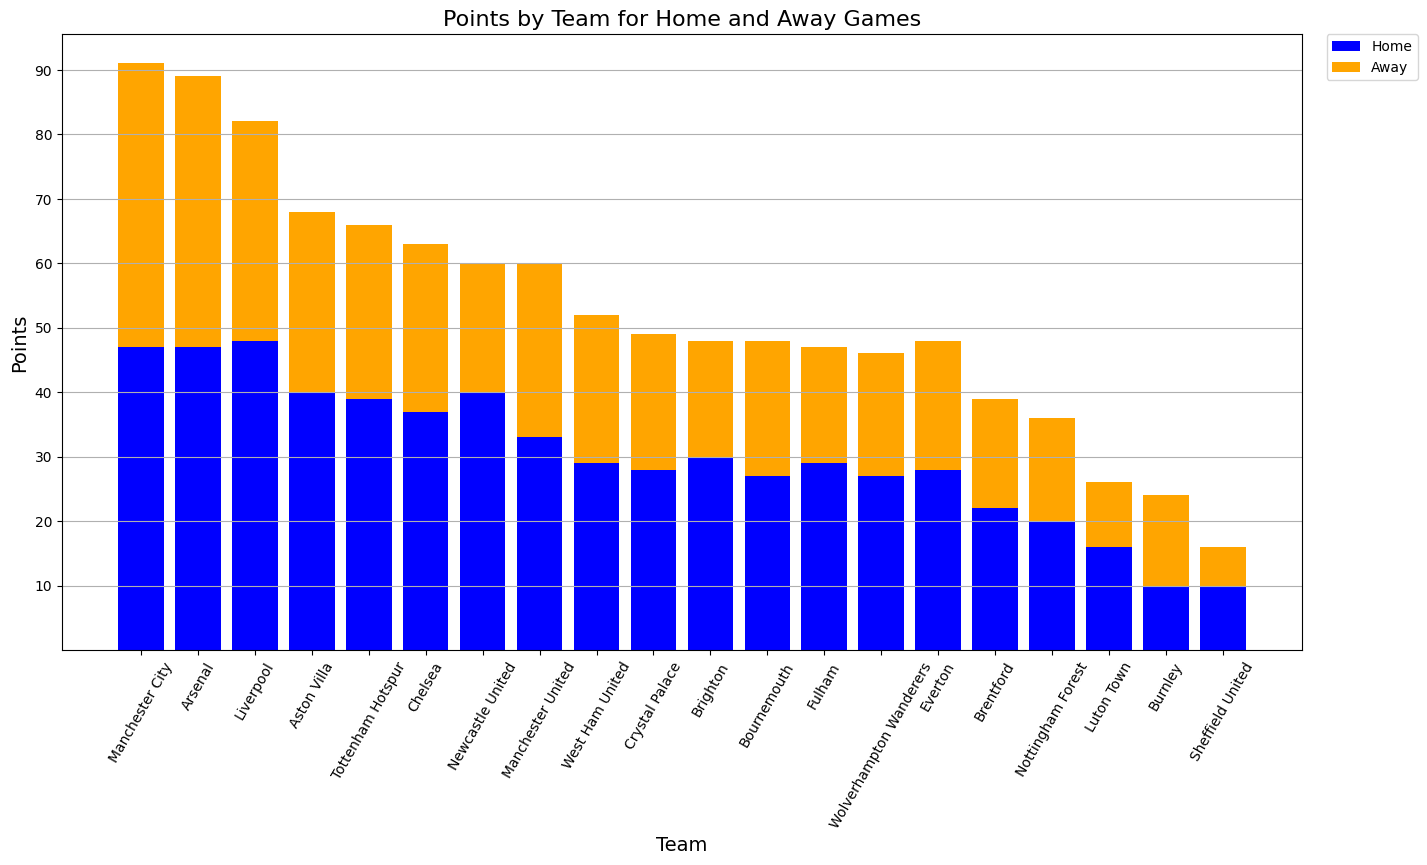

In [24]:
# add labels function
def add_labels(x, y, adjust = 0):
    for i in range(len(x)):
        plt.text(i, y[i] - adjust, y[i])
        
# calculate home points
home_form['Points'] = (home_form['Wins'] * 3) + (home_form['Draws'])

# calulate away points
away_form['Points'] = (away_form['Wins'] * 3) + (away_form['Draws'])

# stacked bar chart of home and away points
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
plt.bar(home_form['Team'], home_form['Points'], color = 'blue')
plt.bar(away_form['Team'], away_form['Points'], bottom = home_form['Points'], color = 'orange')
plt.xlabel('Team', fontsize = 14)
plt.ylabel('Points', fontsize = 14)
plt.title('Points by Team for Home and Away Games', fontsize = 16)
plt.legend(['Home', 'Away'], bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0)
plt.xticks(rotation = 60)
plt.yticks([10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.grid(axis = 'y')
plt.show()

                       Team  Points_home  Points_away  Home_Away_Points_Diff
0           Manchester City           47           44                      3
1                   Arsenal           47           42                      5
2                 Liverpool           48           34                     14
3               Aston Villa           40           28                     12
4         Tottenham Hotspur           39           27                     12
5                   Chelsea           37           26                     11
6          Newcastle United           40           20                     20
7         Manchester United           33           27                      6
8           West Ham United           29           23                      6
9            Crystal Palace           28           21                      7
10                 Brighton           30           18                     12
11              Bournemouth           27           21                      6

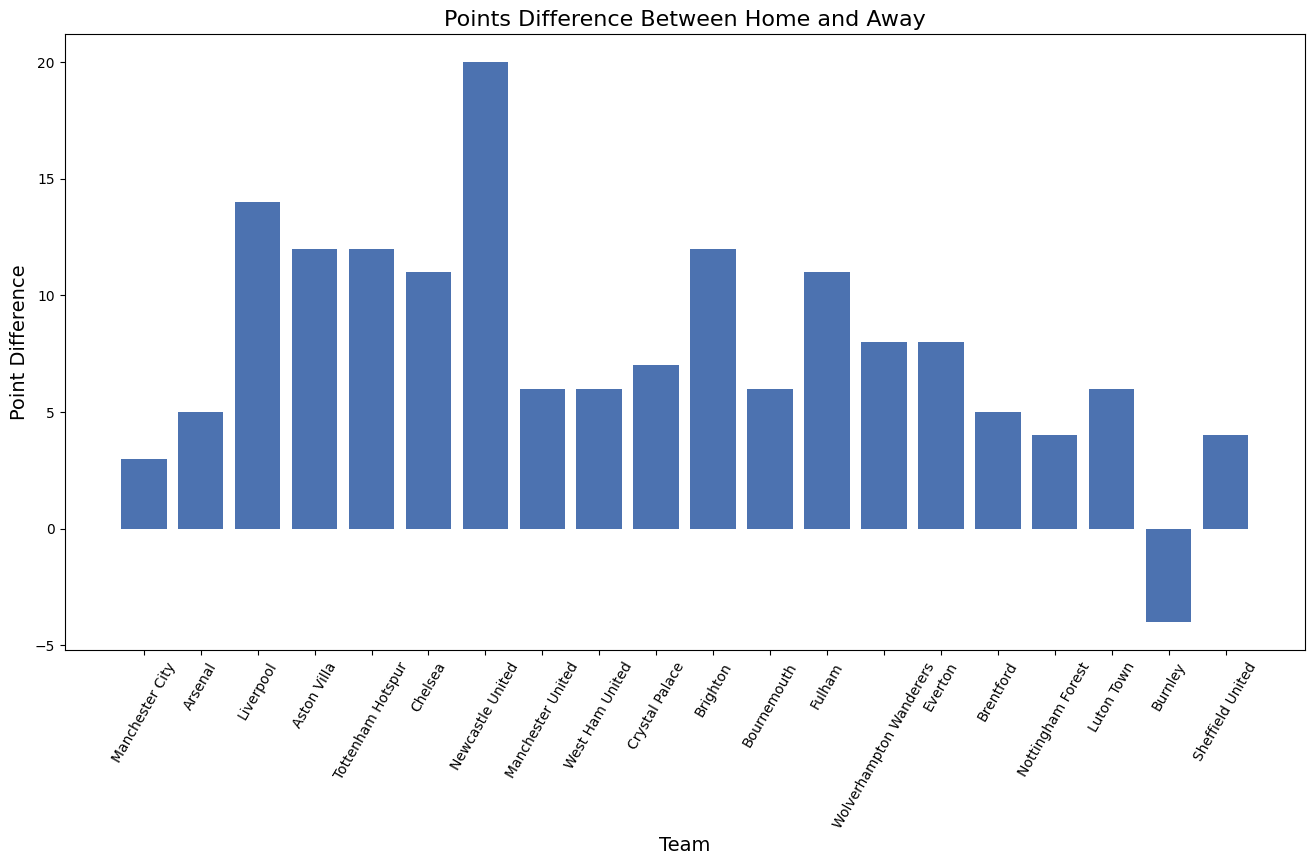

In [25]:
# join home and away form dfs and calculate point difference between the two
home_and_away_points = home_form.merge(away_form, on = 'Team', suffixes = ('_home', '_away'))
home_and_away_points['Home_Away_Points_Diff'] = home_and_away_points['Points_home'] - home_and_away_points['Points_away']
print(home_and_away_points.loc[:, ['Team', 'Points_home', 'Points_away', 'Home_Away_Points_Diff']])

# plot
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
plt.bar(home_and_away_points['Team'], home_and_away_points['Home_Away_Points_Diff'])#, color = home_and_away_points['Home_Away_Points_Diff'])
plt.xlabel('Team', fontsize = 14)
plt.ylabel('Point Difference', fontsize = 14)
plt.title('Points Difference Between Home and Away', fontsize = 16)
plt.xticks(rotation = 60)
plt.show()

It turns out Burnley actually lifted more points from away games than home games in the 23/24 season. Newcastle, Liverpool and Brighton were the three teams to benefit the most from having games played at home, indicating much stronger home form relative to away form. It seems quite unnusual that the team that had the smallest difference between points at home and points away was Manchester City, the league winners. This suggests a high level of consistency regardless of venue.

### 3. Machine Learning
I created machine learning models that attempt to predict whether a game will be a win, draw or loss based on some factors of the game. The factors I'm going to use to predict are:
- Home Team
- Away Team
- Home Possession
- Shots on Target For
- Goals on Target Against

3.1 Data Preprocessing / Feature Engineering
My latter three features were already numerical, but 'Home Team' and 'Away Team', being string values, needed to be encoded. I decided to try modelling with both one-hot encoded and label encoded team names. I suspect one-hot encoded features will work better, as it doesn't suggest an ordinal relationship within the data. 
I also needed to encode the 'W', 'D', and 'L' 

I decided to implement a KNN model as my baseline.

During training I found that onehot encoding was much more effective than label encoding for the win/draw/loss outcomes. This may be because label encoding may introduce ordinal relationships (which do not exist here), and one-hot encoding avoids this problem.


Furthermore, I found that 3 was the best number of neighbors that achieved the highest test accuracy of 72.4%

#### 3.1 Data Preproccessing / Feature Engineering

In [26]:
# subset of features and target
prem_df_ml = prem_df[['Home Team', 'Away Team', 'Home SoT', 'Away SoT', 'Home Poss', 'Home Result']]
prem_df_ml['Home Result'] = prem_df_ml['Home Result'].astype('category')
prem_df_ml['Home Result'] = prem_df_ml['Home Result'].replace({'L': 0,
                                                               'D': 1,
                                                               'W': 2})

prem_df_ml.head()

C:\Users\Odhran\AppData\Local\Temp\ipykernel_3920\2756191014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_df_ml['Home Result'] = prem_df_ml['Home Result'].astype('category')
C:\Users\Odhran\AppData\Local\Temp\ipykernel_3920\2756191014.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prem_df_ml['Home Result'] = prem_df_ml['Home Result'].replace({'L': 0,
C:\Users\Odhran\AppData\Local\Temp\ipykernel_3920\2756191014.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalD

,Home Team,Away Team,Home SoT,Away SoT,Home Poss,Home Result
0,Burnley,Manchester City,1.0,8.0,35.0,0
1,Arsenal,Nottingham Forest,7.0,2.0,78.0,2
2,Brighton,Luton Town,11.0,2.0,70.0,2
3,Sheffield United,Crystal Palace,1.0,8.0,32.0,0
4,Bournemouth,West Ham United,5.0,2.0,62.0,1


In [27]:
# one-hot encoding
prem_df_ml_onehot = pd.get_dummies(prem_df_ml, columns = ['Home Team', 'Away Team'])

prem_df_ml_onehot

,Home SoT,Away SoT,Home Poss,Home Result,Home Team_Arsenal,Home Team_Aston Villa,Home Team_Bournemouth,Home Team_Brentford,Home Team_Brighton,Home Team_Burnley,Home Team_Chelsea,Home Team_Crystal Palace,Home Team_Everton,Home Team_Fulham,Home Team_Liverpool,Home Team_Luton Town,Home Team_Manchester City,Home Team_Manchester United,Home Team_Newcastle United,Home Team_Nottingham Forest,Home Team_Sheffield United,Home Team_Tottenham Hotspur,Home Team_West Ham United,Home Team_Wolverhampton Wanderers,Away Team_Arsenal,Away Team_Aston Villa,Away Team_Bournemouth,Away Team_Brentford,Away Team_Brighton,Away Team_Burnley,Away Team_Chelsea,Away Team_Crystal Palace,Away Team_Everton,Away Team_Fulham,Away Team_Liverpool,Away Team_Luton Town,Away Team_Manchester City,Away Team_Manchester United,Away Team_Newcastle United,Away Team_Nottingham Forest,Away Team_Sheffield United,Away Team_Tottenham Hotspur,Away Team_West Ham United,Away Team_Wolverhampton Wanderers
0,1.0,8.0,35.0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,7.0,2.0,78.0,2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
2,11.0,2.0,70.0,2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,1.0,8.0,32.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,5.0,2.0,62.0,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,3.0,6.0,72.0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
376,12.0,2.0,71.0,2,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
377,5.0,8.0,41.0,0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
378,5.0,2.0,68.0,2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [28]:
# label encoding
prem_df_ml_label = prem_df_ml.copy()
prem_df_ml_label['Home Team'] = prem_df_ml_label['Home Team'].astype('category')
prem_df_ml_label['Home Team Code'] = prem_df_ml_label['Home Team'].cat.codes
prem_df_ml_label['Away Team'] = prem_df_ml_label['Away Team'].astype('category')
prem_df_ml_label['Away Team Code'] = prem_df_ml_label['Away Team'].cat.codes
prem_df_ml_label = prem_df_ml_label.drop(['Home Team', 'Away Team'], axis = 1)
prem_df_ml_label

,Home SoT,Away SoT,Home Poss,Home Result,Home Team Code,Away Team Code
0,1.0,8.0,35.0,0,5,12
1,7.0,2.0,78.0,2,0,15
2,11.0,2.0,70.0,2,4,11
3,1.0,8.0,32.0,0,16,7
4,5.0,2.0,62.0,1,2,18
...,...,...,...,...,...,...
375,3.0,6.0,72.0,0,5,15
376,12.0,2.0,71.0,2,12,18
377,5.0,8.0,41.0,0,11,9
378,5.0,2.0,68.0,2,0,8


Home and Away Shots on Target, and Home Possession are already numeric data types and don't need to be preprocessed. However, machine learning models cannot learn on String data so we need to manipulate 'Home Team' and 'Away Team'. Considering these categories are not ordinal, I predict one-hot encoding will work better than label encoding. I will try both with a simple k-Nearest Neighbours model as a base model.

#### 3.2.1 Base Model - KNN (one-hot encoding)

In [29]:
from sklearn.model_selection import train_test_split

# knn with onehot encoding
X = prem_df_ml_onehot.drop(['Home Result'], axis = 1).values
y = prem_df_ml_onehot['Home Result']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21, stratify = y)

best test accuracy 60.53%
best number of neighbours: 3


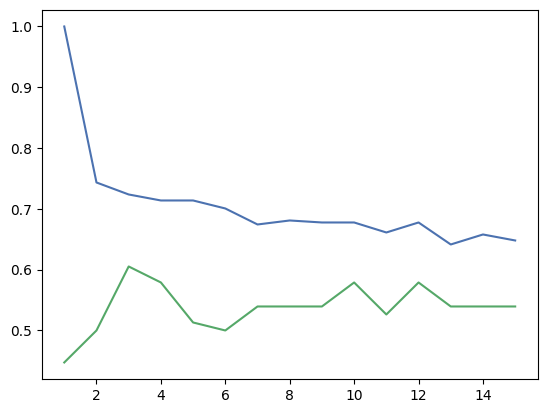

In [30]:
from sklearn.neighbors import KNeighborsClassifier

# param tuning reqs
neighbors = np.arange(1, 16)
train_accuracies = {}
test_accuracies = {}
best_test_accuracy = 0.0
best_n = 0

# check for best number of neighbors
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    train_accuracies[n] = knn.score(X_train, y_train)
    test_accuracies[n] = knn.score(X_test, y_test)
    if test_accuracies[n] > best_test_accuracy:
        best_test_accuracy = test_accuracies[n]
        best_n = n
    
print(f'best test accuracy {best_test_accuracy*100:.2f}%')
print('best number of neighbours: ' + str(best_n))

# plot accuracies by n neighors
plt.plot(neighbors, train_accuracies.values(), label = 'Training Accuracy')
plt.plot(neighbors, test_accuracies.values(), label = 'Testing Accuracy')

As could be expected with three possible outcomes of 'win', 'draw', and 'loss', 3 neighbors makes the most sense for this situation.

#### 3.2.2 Base Model - KNN (label encoding)

In [32]:
# knn with label encoding
X = prem_df_ml_label.drop(['Home Result'], axis = 1).values
y = prem_df_ml_label['Home Result']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21, stratify = y)

{1: 0.5131578947368421, 2: 0.4605263157894737, 3: 0.5, 4: 0.4605263157894737, 5: 0.5131578947368421, 6: 0.47368421052631576, 7: 0.5, 8: 0.4868421052631579, 9: 0.5131578947368421}
best test accuracy 51.32%
best number of neighbours: 1


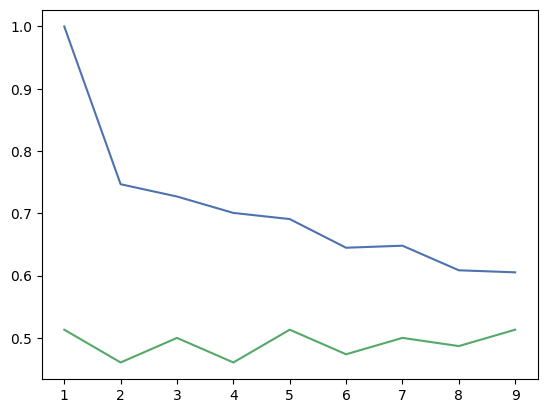

In [33]:
# param tuning reqs
neighbors = np.arange(1, 10)
train_accuracies = {}
test_accuracies = {}
best_test_accuracy = 0.0
best_n = 0

# check for best number of neighbors
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    train_accuracies[n] = knn.score(X_train, y_train)
    test_accuracies[n] = knn.score(X_test, y_test)
    if test_accuracies[n] > best_test_accuracy:
        best_test_accuracy = test_accuracies[n]
        best_n = n

print(f'best test accuracy {best_test_accuracy*100:.2f}%')
print('best number of neighbours: ' + str(best_n))
    
# plot accuracies by n neighors
plt.plot(neighbors, train_accuracies.values(), label = 'Training Accuracy')
plt.plot(neighbors, test_accuracies.values(), label = 'Testing Accuracy')

#### 3.2.3 Comparison Model - Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

# features and targets
X = prem_df_ml_onehot.drop(['Home Result'], axis = 1).values
y = prem_df_ml_onehot['Home Result']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21, stratify = y)

In [35]:
from sklearn.model_selection import GridSearchCV

# random forest classifier model
rf = RandomForestClassifier(random_state = 7)

# hyperparameter tuning
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# initialise gridsearchcv
grid_search = GridSearchCV(estimator = rf, param_grid = rf_params, cv = 5, n_jobs = -1, verbose = 2)

# fit model
grid_search.fit(X_train, y_train)

# best params
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# best score
print(f'Best Score: {grid_search.best_score_ * 100:.2f}%')

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
Best Score: 63.81
